In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fwaf-dataset/badqueries.txt
/kaggle/input/fwaf-dataset/goodqueries.txt


# Import Required Libraries

In [153]:
import numpy as np
import pandas as pd
import datetime
import time
import urllib
import os
import re
import pickle
import nltk
import string
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)


from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [154]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath, "r") as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))
        result.append(d)
    return result

In [155]:
badQueries = loadFile("/kaggle/input/fwaf-dataset/badqueries.txt")
goodQueries = loadFile("/kaggle/input/fwaf-dataset/goodqueries.txt")

In [156]:
bad = pd.DataFrame(badQueries)
good = pd.DataFrame(goodQueries)

In [157]:
bad_df = bad.copy()
good_df = good.copy()

In [158]:
bad_df.columns = ["query"]
good_df.columns = ["query"]

In [159]:
bad_df.head()

,query
0,/scs86g1p.asp?<meta http-equiv=set-cookie cont...
1,/javascript/tiles.exe\n
2,/cgi-local/windmail.exe? -n c:\boot.ini hacker...
3,"/0z575z74.pl?<script>document.cookie=""testuhsv..."
4,; str=$(echo EEKJDE); str1=${#str}; if [ 8 -ne...


In [160]:
good_df.head()

,query
0,/karty2/\n
1,/lm_temp/\n
2,/javascript/servers.as\n
3,/a139501/\n
4,/pt_mbasearch/\n


In [161]:
good_df["label"] = 0
bad_df["label"] = 1

In [162]:
df = pd.concat([good_df, bad_df], axis=0)

In [163]:
df.shape

(1310707, 2)

In [164]:
df = df.sample(frac=1).reset_index(drop=True)

In [165]:
df.head()

,query,label
0,/filedownload-whereisit\x0d_176/\n,0
1,/a638000de537a4a1/\n,0
2,/16145584/\n,0
3,/newsid_2097000/\n,0
4,/ps2-graffiti kingdom pal multi5 fullvd/\n,0


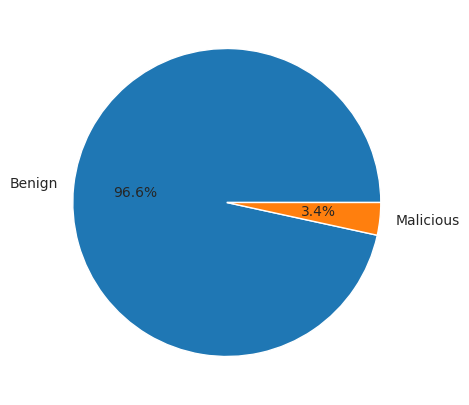

In [166]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Benign", "Malicious"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

# Preprocess

In [167]:
def clean_newline(column):
    column[:-2]
    return column[:-2]

In [168]:
df["query"] = df["query"].apply(clean_newline)

In [169]:
df.head()

,query,label
0,/filedownload-whereisit\x0d_176,0
1,/a638000de537a4a1,0
2,/16145584,0
3,/newsid_2097000,0
4,/ps2-graffiti kingdom pal multi5 fullvd,0


In [170]:
def clear_first_char(column):
    if column.startswith("/"):
        return column[1:]
    else:
        return column

In [171]:
df["query"] = df["query"].apply(clear_first_char)

In [172]:
df.head()

,query,label
0,filedownload-whereisit\x0d_176,0
1,a638000de537a4a1,0
2,16145584,0
3,newsid_2097000,0
4,ps2-graffiti kingdom pal multi5 fullvd,0


In [173]:
def xss_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    xss_pattern=re.compile(r'(<|>|&lt;|&gt;|script|alert|document\.|onload\=|onerror\=|eval\(|expression\(|prompt\(|confirm\()')
    if xss_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [174]:
df["is_xss"] = df["query"].apply(xss_check)

In [175]:
df[df["is_xss"] == 1].head()

,query,label,is_xss
10,ydexw8by.htm?<meta http-equiv=set-cookie conte...,1,1
72,tomcat-docs/appdev/sample/web/hello.jsp?test=<...,1,1
118,zuihld5m.cfm?<script>cross_site_scripting.nasl...,1,1
228,javascript/scripts.wa,0,1
331,encodingdescriptions,1,1


In [176]:
def lfi_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    lfi_pattern = re.compile(r'(file\:\/\/|(\.\.\/)|(\.\.\\))')
    if "=" in input_string.split("/")[-1]:
        if lfi_pattern.search(input_string.split("/")[-1].split("=", 1)[1]):
            return 1
        else:
            return 0
    elif lfi_pattern.search(input_string.split("/")[-1]):
        return 1
    else:
        return 0

In [177]:
df["is_lfi"] = df["query"].apply(lfi_check)

In [178]:
df[df["is_lfi"] == 1].sample(5)

,query,label,is_xss,is_lfi
125789,examples/jsp/jsp2/jspx/search.cgi?..\..\..\..\...,1,0,1
448373,..\\\..\\\..\\\..\\\..\\\..\\\..\\\..\\\{FILE,1,0,1
1301626,error/\..\..\..\..\winnt\win.in,1,0,1
573702,.\..\.\..\{FILE,1,0,1
421807,..\..\\..\{FILE,1,0,1


In [179]:
def command_injection_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    cmd_injection_pattern = re.compile(r'(;|\||`|\$\(|\$\{)')

    if cmd_injection_pattern.search(input_string):
        return 1
    else:
        return 0

In [180]:
df["is_oci"] = df["query"].apply(command_injection_check)

In [181]:
df[df["is_oci"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci
220487,"t3af3tdz.cgi?<img src=""javascript:alert(cross_...",1,1,0,1
771486,examples/jsp/num/athenareg.php?pass= ;i,1,0,0,1
1303431,"quagynka.nsf?<img src=""javascript:alert(cross_...",1,1,0,1
946957,"s7qus4g3.mscgi?<img src=""javascript:alert(cros...",1,1,0,1
970474,"jnt3f86c.kspx?<script>document.cookie=""testcma...",1,1,0,1


In [182]:
def sql_injection_check(input_string):
    input_string = urllib.parse.unquote(input_string)
    sqli_pattern = re.compile(r'(\b(SELECT|INSERT|UPDATE|DELETE|FROM|WHERE|AND|OR|UNION|ALL|EXEC|EXECUTE|DECLARE|CAST)\b)')

    if sqli_pattern.search(input_string):
        return 1
    else:
        return 0

In [183]:
df["is_sqli"] = df["query"].apply(sql_injection_check)

In [184]:
df[df["is_sqli"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli
240217,IF(7423=7423) SELECT 7423 ELSE DROP FUNCTION x...,1,0,0,0,1
1012334,AND 1=1 AND '%'=,1,0,0,0,1
8483,AS INJECTX WHERE 1=1 AND 1=0-,1,0,0,0,1
1235611,AND 7300=7300 AND 'pKlZ'='pKl,1,0,0,0,1
1058924,OR 1=0--,1,0,0,0,1


In [185]:
def semicolon_count(url):
    url = urllib.parse.unquote(url)
    return url.count(";")

In [186]:
df["semicolon_count"] = df["query"].apply(semicolon_count)

In [187]:
df[df["semicolon_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count
39660,"<button onclick=""window.open('http://xss.cx/::...",1,1,0,1,0,1
1214424,"xlj7h65o.do?<script>document.cookie=""testtbbe=...",1,1,0,1,0,1
758808,"tuwjta1w.htm?<script>document.cookie=""testpokn...",1,1,0,1,0,1
51577,main.php?stuff=;rm\x09q93759833\x09,1,0,0,1,0,1
969626,top.php?stuff=;sleep\x097\x09,1,0,0,1,0,1


In [188]:
def underscore_count(url):
    url = urllib.parse.unquote(url)
    return url.count("_")

In [189]:
df["underscore_count"] = df["query"].apply(underscore_count)

In [190]:
df[df["underscore_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count
125770,familiarity_gifts,0,0,0,0,0,0,1
961995,top_title,0,0,0,0,0,0,1
201318,but_map2,0,0,0,0,0,0,1
477001,hacker_ethics,0,0,0,0,0,0,1
424927,dh_killer,0,0,0,0,0,0,1


In [191]:
def questionmark_count(url):
    url = urllib.parse.unquote(url)
    return url.count("?")

In [192]:
df["questionmark_count"] = df["query"].apply(questionmark_count)

In [193]:
df[df["questionmark_count"] > 0].sample(5) 

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count
867543,scripts/index.php?act=sm_window&page=event&day...,1,0,0,0,0,0,1,1
211266,scripts/forum.php?id_article=1&id_forum=-1/**/...,1,0,0,0,0,0,2,1
774822,administrator/components/com_extcalendar/admin...,0,0,0,0,0,0,4,1
994754,php/includes/header.inc.php?root=http://192.16...,0,0,0,0,0,0,0,2
417284,cacti/calendar_admin.pl?config=|cat /etc/passwd,1,0,0,1,0,0,1,1


In [194]:
def equal_count(url):
    url = urllib.parse.unquote(url)
    return url.count("=")

In [195]:
df["equal_count"] = df["query"].apply(equal_count)

In [196]:
df[df["equal_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count
377298,administrator/components/com_jcs/jcs.function....,0,0,0,0,0,0,3,1,1
197651,help.php?q=uname\x09>q77267797\x09,1,1,0,0,0,0,0,1,1
830730,examples/jsp/jsp2/el/admin/top.php?admindir=/e...,1,0,0,0,0,0,0,1,1
466548,components/com_articles.php?absolute_path=http...,0,0,0,0,0,0,2,2,1
785279,classes/html/com_articles.php?absolute_path=ht...,0,0,0,0,0,0,2,1,1


In [197]:
def and_count(url):
    url = urllib.parse.unquote(url)
    return url.count("&")

In [198]:
df["and_count"] = df["query"].apply(equal_count)

In [199]:
df[df["and_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count
1246024,manual/ja/ko/?d=,0,0,0,0,0,0,0,1,1,1
39794,widgets/base/footer.php?sys_dir=http://192.168...,0,0,0,0,0,0,1,1,1,1
1142535,dir_phnntp/article-raw.php?file_newsportal=htt...,0,0,0,0,0,0,2,2,1,1
238821,ovcgi/ifacemgr/setmon.ovpl?action=continue&hos...,0,0,0,1,0,0,5,1,2,2
179370,cgi-exe/fileseek2.cgi?foot=....//....//....//....,1,0,0,0,0,0,0,1,1,1


In [200]:
def or_count(url):
    url = urllib.parse.unquote(url)
    return url.count("|")

In [201]:
df["or_count"] = df["query"].apply(or_count)

In [202]:
df[df["or_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count
1029058,a)|id,1,0,0,1,0,0,0,0,0,0,1
736251,"""||echo$IFSWVBHRV$((70+26))$(echo$IFSWVBHRV)WV...",1,0,0,1,0,0,0,0,0,0,2
57084,"""|echo WYANEK$((66+6))$(echo WYANEK)WYANEK",1,0,0,1,0,0,0,0,0,0,1
915709,top.php?stuff='|sleep 7,1,0,0,1,0,0,0,1,1,1,1
742889,%27| [ 3 -ne $(echo FMCMJN | tr -d '\n' | wc -...,1,0,0,1,0,0,0,0,0,0,5


In [203]:
def dotcount(url):
    url = urllib.parse.unquote(url)
    return url.count(".")

In [204]:
df["dot_count"] = df["query"].apply(dotcount)

In [205]:
df[df["dot_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count
187863,edzaia0i.pl?<script>cross_site_scripting.nasl<...,1,1,0,0,0,0,2,1,0,0,0,2
1246468,javascript/trunk.w,0,0,0,0,0,0,0,0,0,0,0,1
190085,javascript/overview.svn-bas,0,0,0,0,0,0,0,0,0,0,0,1
1283659,javascript/charge.ra,0,0,0,0,0,0,0,0,0,0,0,1
1118904,javascript/es.da,0,0,0,0,0,0,0,0,0,0,0,1


In [206]:
def atcount(url):
    url = urllib.parse.unquote(url)
    return url.count("@")

In [207]:
df["at_count"] = df["query"].apply(atcount)

In [208]:
df[df["at_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count
1301965,afb-3-beta-2007-08-28/_includes/settings.inc.p...,0,0,0,0,0,0,1,1,1,1,0,2,1
845881,security/include/_class.security.php?phpsecuri...,0,0,0,0,0,0,2,1,1,1,0,2,1
109555,components/com_htmlarea3_xtd-c/popups/imageman...,0,0,0,0,0,0,4,1,1,1,0,2,1
133232,includes/bbcb_mg.php?phpbb_root_path=@rfiurl?p...,0,0,0,0,0,0,5,2,2,2,0,1,2
719132,en-us/static/@95063/js/messenger.j,0,0,0,0,0,0,0,0,0,0,0,1,1


In [209]:
def subdircount(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    subdirectory_path = len(parsed_url.path.strip("/").split("/"))
    return subdirectory_path

In [210]:
df["subdir_count"] = df["query"].apply(subdircount)

In [211]:
df[df["subdir_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count
242399,worldscreaturesmiddlecol-05,0,0,0,0,0,0,0,0,0,0,0,0,0,1
64861,10710000,0,0,0,0,0,0,0,0,0,0,0,0,0,1
253950,dl6421,0,0,0,0,0,0,0,0,0,0,0,0,0,1
234702,install.php?_ne[abspath]=http://192.168.202.11...,0,0,0,0,0,0,1,1,1,1,0,4,0,1
63216,trojbancosdr,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [212]:
def query_len(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = "".join(f"{value[0]}" for key, value in query_params.items())    
        return len(query_string)
    else:
        return 0

In [213]:
df["query_len"] = df["query"].apply(query_len)

In [214]:
df[df["query_len"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len
211646,"main.php?stuff=""&ping\x09-w\x0910000\x09-n\x09...",1,0,0,0,0,0,0,1,1,1,0,4,0,1,1
184668,en-us/module/search/flashchart/statusmessage?e...,0,0,0,0,0,0,1,1,3,3,0,1,0,5,25
175468,"h5sc3gxy.fts?<img src=""javascript:alert(cross_...",1,1,0,1,0,1,2,1,1,1,0,2,0,1,46
513795,administrator/components/com_clickheat/Recly/C...,1,0,0,0,0,0,4,1,1,1,0,1,0,6,7
1039299,hrttz9fj.jspa?<meta http-equiv=set-cookie cont...,1,1,0,0,0,0,0,1,3,3,0,1,0,1,34


In [215]:
def param_count(url):
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    return len(query_params)

In [216]:
df["param_count"] = df["query"].apply(param_count)

In [217]:
df[df["param_count"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count
319117,index.php?ads_file=http://cirt.net/rfiinc.txt,0,0,0,0,0,0,1,1,1,1,0,3,0,1,26,1
507818,new_images.php?order=linpha_order_sql_injectio...,0,0,0,0,0,0,5,1,1,1,0,2,0,1,41,1
750742,plugins/spamx/ipofurl.examine.class.php?_conf[...,0,0,0,0,0,0,1,1,1,1,0,6,0,3,42,1
824493,files/message-replyall.php3?bsx_libdir=http://...,0,0,0,0,0,0,1,1,1,1,0,4,0,2,40,1
505827,examples/jsp/cal/calendar.php?month=' union se...,1,0,0,0,0,0,3,1,1,1,0,2,0,4,72,1


In [218]:
def total_digits_in_url(url):
    total_digits = 0
    for text in list(map(str, "0123456789")):
        total_digits += url.lower().count(text)
        
    return total_digits

In [219]:
df["total_digits_url"] = df["query"].apply(total_digits_in_url)

In [220]:
df[df["total_digits_url"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url
1094190,pno_86099148,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,8
58280,ns6285905775,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10
1123995,"""||echo$IFSKQELND$((18+15))$(echo$IFSKQELND)KQ...",1,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0,4
751046,555663292ebeozn,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9
895076,whofcsservesbroch2006s,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4


In [221]:
def total_letter_in_url(url):
    total_letter = 0
    for text in url:
        if text not in "0123456789":
            if text not in string.punctuation:
                total_letter += 1
        
    return total_letter

In [222]:
df["total_letter_url"] = df["query"].apply(total_letter_in_url)

In [223]:
df[df["total_letter_url"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url
979216,icon-inaug,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,9
608475,admin/images/notify_update.pn,0,0,0,0,0,0,1,0,0,0,0,1,0,3,0,0,0,25
863166,javascript/running.ms,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,19
1160538,javascript/at.dl,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,14
540430,javascript/jessica.pf,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,19


In [224]:
tokenizer = RegexpTokenizer(r"[A-Za-z]+")

In [225]:
df["url_tokenized"] = df["query"].apply(lambda x: tokenizer.tokenize(x))

In [226]:
df[df["url_tokenized"] != "[]"].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized
504885,sahafa,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,[sahafa]
400748,javascript/children.tar.bz,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,23,"[javascript, children, tar, bz]"
347874,javascript/webaccess.a,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,20,"[javascript, webaccess, a]"
263353,navbugs,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,[navbugs]
394007,3523316,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,0,[]


In [227]:
stemmer = SnowballStemmer("english")

In [228]:
def stem_url(column):
    words = [stemmer.stem(word) for word in column if len(word) >= 3]
    return " ".join(words)

In [229]:
df["url_stemmed"] = df["url_tokenized"].apply(stem_url)

In [230]:
df[df["url_stemmed"] != "[]"].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed
480486,ec-38_s,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,2,3,"[ec, s]",
73140,4922883,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,0,[],
512576,20060822com,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,3,[com],com
405953,002631,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],
952111,smvirusmailsummary,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,18,[smvirusmailsummary],smvirusmailsummari


In [231]:
def total_digits_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_digits_in_url(until_last_directory)
    else:
        return 0

In [232]:
df["total_digits_domain"] = df["query"].apply(total_digits_domain)

In [233]:
df[df["total_digits_domain"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain
1141837,podcastgen1.0beta2/core/admin/categories.php?c...,0,0,0,0,0,0,0,1,4,4,0,5,0,4,56,4,21,102,"[podcastgen, beta, core, admin, categories, ph...",podcastgen beta core admin categori php catego...,3
160216,en-us/modules/@95063/include/serversideinclude.j,0,0,0,0,0,0,0,0,0,0,0,1,1,5,0,0,5,36,"[en, us, modules, include, serversideinclude, j]",modul includ serversideinclud,5
1105139,<style>p[foo=bar{}*{-o-link:'javascript:javasc...,1,0,0,1,0,1,0,0,1,1,0,0,0,2,0,0,1,73,"[style, p, foo, bar, o, link, javascript, java...",style foo bar link javascript javascript alert...,1
319828,examples/jsp/jsp2/jspx/new-visitor.inc.php?lvc...,0,0,0,0,0,0,2,1,1,1,0,2,0,5,14,1,1,58,"[examples, jsp, jsp, jspx, new, visitor, inc, ...",exampl jsp jsp jspx new visitor inc php lvc in...,1
1179130,0x2e0x2e/0x2e0x2e/{FILE,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,8,12,"[x, e, x, e, x, e, x, e, FILE]",file,8


In [234]:
def total_letter_domain(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        until_last_directory = "".join([word for word in path_components[:-1]])
        return total_letter_in_url(until_last_directory)
    else:
        return 0

In [235]:
df["total_letter_domain"] = df["query"].apply(total_letter_domain)

In [236]:
df[df["total_letter_domain"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain
553703,javascript/trees.in,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,17,"[javascript, trees, in]",javascript tree,0,10
128688,javascript/common.pd,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,18,"[javascript, common, pd]",javascript common,0,10
714873,lib/classes/swift/streamfilters/portal/diag/in...,0,0,0,0,0,0,0,0,0,0,0,1,0,7,0,0,0,45,"[lib, classes, swift, streamfilters, portal, d...",lib class swift streamfilt portal diag index,0,38
624126,javascript/binary.in,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,18,"[javascript, binary, in]",javascript binari,0,10
899584,javascript/surveys.v,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,18,"[javascript, surveys, v]",javascript survey,0,10


In [237]:
def total_digits_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_digits_in_url(last_directory)
    else:
        return total_digits_in_url(clean_url)

In [238]:
df["total_digits_path"] = df["query"].apply(total_digits_path)

In [239]:
df[df["total_digits_path"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path
7330,277355,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],,0,0,6
576252,32474-affic,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,5,[affic],affic,0,0,5
460527,000066750,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,9,0,[],,0,0,9
1108568,119510,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],,0,0,6
276996,102500,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,6,0,[],,0,0,6


In [240]:
def total_letter_path(url):
    parsed_url = urllib.parse.urlparse(url)
    clean_url = url.replace(parsed_url.query, "")
    path_components = [component for component in clean_url.split('/') if component]
    if path_components:
        last_directory = "".join([word for word in path_components[-1]])
        return total_letter_in_url(last_directory)
    else:
        return total_letter_in_url(clean_url)

In [241]:
df["total_letter_path"] = df["query"].apply(total_letter_path)

In [242]:
df[df["total_letter_path"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path
661567,javascript/job.js,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,15,"[javascript, job, js]",javascript job,0,10,0,5
439706,mimg-6tfr5c,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,8,"[mimg, tfr, c]",mimg tfr,0,0,2,8
968998,s1757142,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,1,[s],,0,0,7,1
127713,ddaward,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,7,[ddaward],ddaward,0,0,0,7
608487,sites100,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,5,[sites],site,0,0,3,5


In [243]:
def has_extension(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not query_params or not file_extension:
        return 0
    else:
        return 1

In [244]:
df["has_extension"] = df["query"].apply(has_extension)

In [245]:
df[df["has_extension"] == 1].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension
623276,chat.php?config[mwchat_libs]=http://cirt.net/r...,0,0,0,0,0,0,1,2,1,1,0,3,0,1,27,1,0,43,"[chat, php, config, mwchat, libs, http, cirt, ...",chat php config mwchat lib http cirt net rfiin...,0,0,0,7,1
452344,stphpapplication.php?stphplib_dir=http://192.1...,0,0,0,0,0,0,1,1,1,1,0,4,0,1,42,1,16,48,"[stphpapplication, php, stphplib, dir, http, m...",stphpapplic php stphplib dir http moclyxlwqyfjnp,0,0,0,19,1
1085333,classes/class_mail.inc.php?path_to_folder=http...,0,0,0,0,0,0,3,1,1,1,0,5,0,2,40,1,16,50,"[classes, class, mail, inc, php, path, to, fol...",class class mail inc php path folder http ghqi...,0,7,0,15,1
1078916,inc/settings.php?inc_dir=http://192.168.202.11...,0,0,0,0,0,0,1,1,1,1,0,4,0,2,40,1,17,35,"[inc, settings, php, inc, dir, http, zz, thkvt...",inc set php inc dir http thkvtmlgl,0,3,0,11,1
1283447,ncaster/admin/addons/archive/archive.php?admin...,0,0,0,0,0,0,0,1,1,1,0,4,0,5,34,1,17,55,"[ncaster, admin, addons, archive, archive, php...",ncaster admin addon archiv archiv php adminfol...,0,25,0,10,1


In [246]:
def find_extension(url):
    url = urllib.parse.unquote(url)
    parsed_url = urllib.parse.urlparse(url)
    query_params = urllib.parse.parse_qs(parsed_url.query)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1]
    if not file_extension:
        return ""
    else:
        return file_extension

In [247]:
df["extension"] = df["query"].apply(find_extension)

In [248]:
df[df["extension"] != ""].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension
1024777,javascript/templ.bz,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,17,"[javascript, templ, bz]",javascript templ,0,10,0,7,0,.bz
306841,javascript/bob.md,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,15,"[javascript, bob, md]",javascript bob,0,10,0,5,0,.md
663179,javascript/networking.cf,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,22,"[javascript, networking, cf]",javascript network,0,10,0,12,0,.cf
768686,javascript/sunos.vb,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,17,"[javascript, sunos, vb]",javascript suno,0,10,0,7,0,.vb
105855,images/b_edit.pn,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,13,"[images, b, edit, pn]",imag edit,0,6,0,7,0,.pn


In [249]:
def has_parameter(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        return 1
    else:
        return 0

In [250]:
df["has_parameter"] = df["query"].apply(has_parameter)

In [251]:
df[df["has_parameter"] > 0].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter
468512,forum1_professionnel.asp?n=1771&amp;nn=../../....,1,0,0,1,0,2,1,1,3,3,0,19,0,1,45,2,7,44,"[forum, professionnel, asp, n, amp, nn, etc, p...",forum professionnel asp amp etc passwd amp page,0,0,1,21,1,.asp,1
324822,en-us/account/ustorekeeper.pl?command=goto&fil...,1,0,0,0,0,0,0,1,2,2,0,21,0,3,43,2,0,48,"[en, us, account, ustorekeeper, pl, command, g...",account ustorekeep command goto file etc passw,0,11,0,14,1,.pl,1
863130,moodle/filter/tex/texed.php?formdata=foo&pathn...,1,0,0,1,0,3,0,1,2,2,0,1,0,4,40,2,3,66,"[moodle, filter, tex, texed, php, formdata, fo...",moodl filter tex tex php formdata foo pathnam ...,0,15,0,8,1,.php,1
938838,components/com_nfn_addressbook/nfnaddressbook....,1,0,0,0,0,0,4,1,1,1,0,1,0,3,8,1,0,73,"[components, com, nfn, addressbook, nfnaddress...",compon com nfn addressbook nfnaddressbook php ...,0,27,0,17,1,.php,1
1194635,mods/ui_functions.php?gallery_basedir=http://1...,0,0,0,0,0,0,2,1,1,1,0,4,0,2,40,1,18,46,"[mods, ui, functions, php, gallery, basedir, h...",mod function php galleri basedir http aibfaczmac,0,4,0,14,1,.php,1


In [252]:
def find_parameter_name(url):
    parsed_url = urllib.parse.urlparse(url)
    if len(parsed_url.query) > 0:
        query_params = urllib.parse.parse_qs(parsed_url.query)
        query_string = " ".join(f"{key}" for key, value in query_params.items())    
        return query_string
    else:
        return ""

In [253]:
df["parameters"] = df["query"].apply(find_parameter_name)

In [254]:
df[df["parameters"] != ""].sample(5)

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
30264,main.php?logout='&uname,1,0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,19,"[main, php, logout, uname]",main php logout unam,0,0,0,7,1,.php,1,logout
332519,classes/auth/openid/urinorm.php?_env[asicms][p...,0,0,0,0,0,0,1,1,1,1,0,4,0,4,39,1,16,55,"[classes, auth, openid, urinorm, php, env, asi...",class auth openid urinorm php env asicm path h...,0,17,0,10,1,.php,1,_env[asicms][path]
1299211,stylesheet.php?version=133191953,0,0,0,0,0,0,0,1,1,1,0,1,0,1,9,1,9,20,"[stylesheet, php, version]",stylesheet php version,0,0,0,13,1,.php,1,version
1098200,admin/plugins/online_users/main.php?globals[pt...,0,0,0,0,0,0,2,1,1,1,0,1,1,4,6,1,0,57,"[admin, plugins, online, users, main, php, glo...",admin plugin onlin user main php global config...,0,23,0,7,1,.php,1,globals[pt_config][dir][data]
738768,amazon/cart.php?cmd=add&asin=XXpathX,1,0,0,0,0,0,0,1,2,2,0,1,0,2,10,2,0,30,"[amazon, cart, php, cmd, add, asin, XXpathX]",amazon cart php cmd add asin xxpathx,0,6,0,7,1,.php,1,cmd asin


In [255]:
df.columns

Index(['query', 'label', 'is_xss', 'is_lfi', 'is_oci', 'is_sqli',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'url_tokenized', 'url_stemmed',
       'total_digits_domain', 'total_letter_domain', 'total_digits_path',
       'total_letter_path', 'has_extension', 'extension', 'has_parameter',
       'parameters'],
      dtype='object')

In [256]:
features = ['is_xss', 'is_lfi', 'is_oci', 'is_sqli',
       'semicolon_count', 'underscore_count', 'questionmark_count',
       'equal_count', 'and_count', 'or_count', 'dot_count', 'at_count',
       'subdir_count', 'query_len', 'param_count', 'total_digits_url',
       'total_letter_url', 'total_digits_domain', 'total_letter_domain', 
       'total_digits_path', 'total_letter_path', 'has_extension','has_parameter']

In [257]:
df.head()

,query,label,is_xss,is_lfi,is_oci,is_sqli,semicolon_count,underscore_count,questionmark_count,equal_count,and_count,or_count,dot_count,at_count,subdir_count,query_len,param_count,total_digits_url,total_letter_url,url_tokenized,url_stemmed,total_digits_domain,total_letter_domain,total_digits_path,total_letter_path,has_extension,extension,has_parameter,parameters
0,filedownload-whereisit\x0d_176,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,4,23,"[filedownload, whereisit, x, d]",filedownload whereisit,0,0,4,23,0,,0,
1,a638000de537a4a1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,11,5,"[a, de, a, a]",,0,0,11,5,0,,0,
2,16145584,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,8,0,[],,0,0,8,0,0,,0,
3,newsid_2097000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,7,6,[newsid],newsid,0,0,7,6,0,,0,
4,ps2-graffiti kingdom pal multi5 fullvd,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,35,"[ps, graffiti, kingdom, pal, multi, fullvd]",graffiti kingdom pal multi fullvd,0,0,2,35,0,,0,


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310707 entries, 0 to 1310706
Data columns (total 29 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   query                1310707 non-null  object
 1   label                1310707 non-null  int64 
 2   is_xss               1310707 non-null  int64 
 3   is_lfi               1310707 non-null  int64 
 4   is_oci               1310707 non-null  int64 
 5   is_sqli              1310707 non-null  int64 
 6   semicolon_count      1310707 non-null  int64 
 7   underscore_count     1310707 non-null  int64 
 8   questionmark_count   1310707 non-null  int64 
 9   equal_count          1310707 non-null  int64 
 10  and_count            1310707 non-null  int64 
 11  or_count             1310707 non-null  int64 
 12  dot_count            1310707 non-null  int64 
 13  at_count             1310707 non-null  int64 
 14  subdir_count         1310707 non-null  int64 
 15  query_len      

In [259]:
# Feature Scaling

In [260]:
X = df.drop(["query","label", "url_tokenized", "url_stemmed", "extension", "parameters"], axis=1)
y = df["label"]

In [261]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [263]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [264]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train.ravel())

# Model

In [278]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,TextVectorization

In [279]:
model = Sequential()

In [280]:
model.add(Dense(64,input_dim=X_train.shape[1],activation="relu"))
model.add(Dropout(rate =0.5))

model.add(Dense(1,activation="sigmoid"))


In [285]:
model.compile('adam', loss = 'binary_crossentropy',metrics=["accuracy"])

In [286]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                1536      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1601 (6.25 KB)
Trainable params: 1601 (6.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [287]:
firebytes = model.fit(X_train,y_train,epochs=5,validation_split=0.2)

Epoch 1/5
50641/50641 [==============================] - 155s 3ms/step - loss: 0.1565 - accuracy: 0.9429 - val_loss: 0.2174 - val_accuracy: 0.8965
Epoch 2/5
50641/50641 [==============================] - 154s 3ms/step - loss: 0.1480 - accuracy: 0.9464 - val_loss: 0.2220 - val_accuracy: 0.8900
Epoch 3/5
50641/50641 [==============================] - 153s 3ms/step - loss: 0.1467 - accuracy: 0.9476 - val_loss: 0.2234 - val_accuracy: 0.8947
Epoch 4/5
50641/50641 [==============================] - 153s 3ms/step - loss: 0.1468 - accuracy: 0.9484 - val_loss: 0.2229 - val_accuracy: 0.9042
Epoch 5/5
50641/50641 [==============================] - 152s 3ms/step - loss: 0.1460 - accuracy: 0.9488 - val_loss: 0.2205 - val_accuracy: 0.9022


In [288]:
firebytes.history

{'loss': [0.15648716688156128,
  0.1480197310447693,
  0.14673101902008057,
  0.14677755534648895,
  0.14604684710502625],
 'accuracy': [0.9428738355636597,
  0.946445643901825,
  0.9475557804107666,
  0.9483524560928345,
  0.9487937092781067],
 'val_loss': [0.21741460263729095,
  0.22202076017856598,
  0.22339701652526855,
  0.2229406237602234,
  0.220516636967659],
 'val_accuracy': [0.8964928984642029,
  0.8900059461593628,
  0.894690990447998,
  0.9042016863822937,
  0.9022393226623535]}

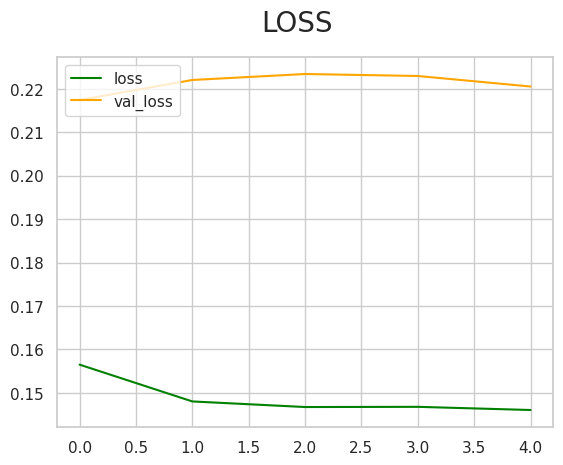

In [296]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(firebytes.history['loss'], color = 'green', label='loss')
plt.plot(firebytes.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('LOSS', fontsize=20)
plt.legend(loc='upper left')
plt.show()

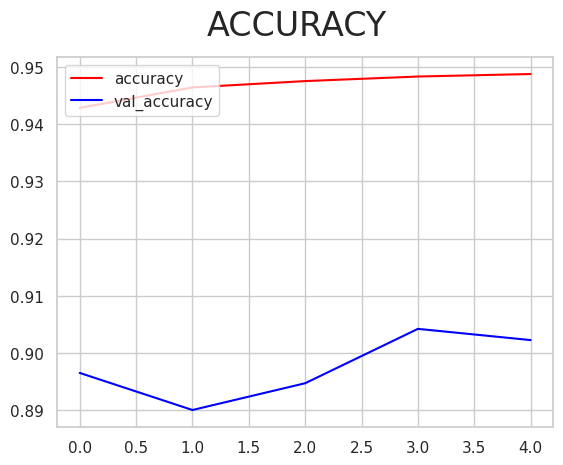

In [298]:
fig =plt.figure()
plt.plot(firebytes.history['accuracy'], color = 'red' , label='accuracy')
plt.plot(firebytes.history['val_accuracy'], color = 'blue' , label = 'val_accuracy')
plt.suptitle("ACCURACY",fontsize=24)
plt.legend(loc="upper left")
plt.show()

In [305]:
y_pred = model.predict(X_test)

8192/8192 [==============================] - 10s 1ms/step


In [306]:
print(y_pred.mean())

0.0864313


In [307]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [312]:

precision = Precision()(y_test, y_pred)
recall = Recall()(y_test, y_pred)
binary_accuracy = BinaryAccuracy()(y_test, y_pred)

print(f'Precision: {precision.numpy():.4f}')
print(f'Recall: {recall.numpy():.4f}')
print(f'Binary Accuracy: {binary_accuracy.numpy():.4f}')



Precision: 0.6497
Recall: 0.8932
Binary Accuracy: 0.9799
